In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from A_TOOLBOX import *
import re
import pickle
import bootcampviztools as bt

from sklearn.metrics import median_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv('../data/train.csv')

## Data exploration

In [3]:
describe_df(df)

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
DATA_TYPE,int64,int64,object,object,object,float64,object,object,object,object,object,object,object,float64
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,912,912,19,475,6,15,35,104,8,36,91,9,158,614
CARDIN (%),100.0,100.0,2.08,52.08,0.66,1.64,3.84,11.4,0.88,3.95,9.98,0.99,17.32,67.32


In [4]:
df.head()

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,268,1002,Dell,Inspiron 5567,Notebook,15.6,1366x768,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,AMD Radeon R7 M445,Windows 10,2.36kg,749.00
1,347,867,Asus,X541NA (N4200/4GB/1TB/W10),Notebook,15.6,1366x768,Intel Pentium Quad Core N4200 1.1GHz,4GB,1TB HDD,Intel HD Graphics 505,Windows 10,2kg,449.00
2,353,966,Toshiba,Portege Z30-C-1CW,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.2kg,1460.00
3,578,767,Dell,Alienware 17,Gaming,15.6,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,4.42kg,2868.99
4,42,1241,Dell,Latitude E7270,Ultrabook,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.26kg,1713.37


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                912 non-null    int64  
 1   laptop_ID         912 non-null    int64  
 2   Company           912 non-null    object 
 3   Product           912 non-null    object 
 4   TypeName          912 non-null    object 
 5   Inches            912 non-null    float64
 6   ScreenResolution  912 non-null    object 
 7   Cpu               912 non-null    object 
 8   Ram               912 non-null    object 
 9   Memory            912 non-null    object 
 10  Gpu               912 non-null    object 
 11  OpSys             912 non-null    object 
 12  Weight            912 non-null    object 
 13  Price_euros       912 non-null    float64
dtypes: float64(2), int64(2), object(10)
memory usage: 99.9+ KB


In [6]:
target = 'Price_euros'

In [7]:
train, test = train_test_split(df, test_size = 0.2, random_state = 42)

## Data processing

#### laptop_ID / Product

In [108]:
columns_exclude = ['laptop_ID', 'Product', 'id']

#### Weight

In [9]:
# Tratamiento de Weight --> quitar "Kg" y convertir a float:
def convertir_peso(peso):
    return float(peso.replace("kg", ""))

train['Peso_kg'] = train['Weight'].apply(convertir_peso)
# ------- TEST -------

test['Peso_kg'] = test['Weight'].apply(convertir_peso)

# --------------------

In [109]:
columns_exclude.append('Weight')
train.head(1)

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,...,Hybrid_GB,Gama_CPU,Gama_GPU,Num_Pixeles,IPS,HD,Touchscreen,4K,Retina,Quad HD+
25,829,41,Asus,X540UA-DM186 (i3-6006U/4GB/1TB/FHD/Linux),Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,1TB HDD,...,0,2,1,2073600,0,1,0,0,0,0


#### RAM

In [11]:
# Ram --> Quitar GB y convertir a float:
def convertir_ram(memo):
    return float(memo.replace("GB", ""))

train['RAM_GB'] = train['Ram'].apply(convertir_ram)

# ------- TEST -------

test['RAM_GB'] = test['Ram'].apply(convertir_ram)

# --------------------

In [110]:
columns_exclude.append('Ram')
train.head(1)

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,...,Hybrid_GB,Gama_CPU,Gama_GPU,Num_Pixeles,IPS,HD,Touchscreen,4K,Retina,Quad HD+
25,829,41,Asus,X540UA-DM186 (i3-6006U/4GB/1TB/FHD/Linux),Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,1TB HDD,...,0,2,1,2073600,0,1,0,0,0,0


#### Memory

In [13]:
# Memory --> Poner todo en la misma medida y separar por tipo de memoria
train['Memory'].unique()

array(['1TB HDD', '256GB SSD', '2TB HDD', '128GB SSD', '512GB SSD',
       '512GB Flash Storage', '240GB SSD', '256GB SSD +  1TB HDD',
       '128GB Flash Storage', '512GB SSD +  1TB HDD', '500GB HDD',
       '1TB SSD', '128GB SSD +  1TB HDD', '64GB Flash Storage',
       '32GB Flash Storage', '256GB SSD +  500GB HDD', '1.0TB Hybrid',
       '16GB Flash Storage', '1.0TB HDD', '1TB SSD +  1TB HDD',
       '256GB SSD +  2TB HDD', '256GB Flash Storage',
       '128GB SSD +  2TB HDD', '32GB HDD', '180GB SSD',
       '64GB Flash Storage +  1TB HDD', '256GB SSD +  1.0TB Hybrid',
       '64GB SSD', '32GB SSD', '16GB SSD', '1TB HDD +  1TB HDD',
       '512GB SSD +  1.0TB Hybrid', '8GB SSD', '512GB SSD +  512GB SSD',
       '256GB SSD +  256GB SSD', '512GB SSD +  2TB HDD'], dtype=object)

In [14]:
def valores_a_GB (value):
    if 'TB' in value:
        return int(float(value.replace('TB', '').strip()) * 1000)
    elif 'GB' in value:
        return int(float(value.replace('GB', '').strip()))
    return 0

def tipo_memoria (storage, storage_type):
    if storage_type not in storage:
        return 0
    matches = re.findall(r'(\d+(?:\.\d+)?\s*TB|\d+\s*GB)\s*' + storage_type, storage)
    total_gb = sum(valores_a_GB(match) for match in matches)
    return total_gb

In [15]:
train['SSD_GB'] = train['Memory'].apply(lambda x: tipo_memoria(x, 'SSD'))
train['HDD_GB'] = train['Memory'].apply(lambda x: tipo_memoria(x, 'HDD'))
train['Flash_Storage_GB'] = train['Memory'].apply(lambda x: tipo_memoria(x, 'Flash Storage'))
train['Hybrid_GB'] = train['Memory'].apply(lambda x: tipo_memoria(x, 'Hybrid'))

# ------- TEST -------

test['SSD_GB'] = test['Memory'].apply(lambda x: tipo_memoria(x, 'SSD'))
test['HDD_GB'] = test['Memory'].apply(lambda x: tipo_memoria(x, 'HDD'))
test['Flash_Storage_GB'] = test['Memory'].apply(lambda x: tipo_memoria(x, 'Flash Storage'))
test['Hybrid_GB'] = test['Memory'].apply(lambda x: tipo_memoria(x, 'Hybrid'))

# --------------------

In [111]:
columns_exclude.append('Memory')
train.head(1)

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,...,Hybrid_GB,Gama_CPU,Gama_GPU,Num_Pixeles,IPS,HD,Touchscreen,4K,Retina,Quad HD+
25,829,41,Asus,X540UA-DM186 (i3-6006U/4GB/1TB/FHD/Linux),Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,1TB HDD,...,0,2,1,2073600,0,1,0,0,0,0


#### CPU

In [17]:
# CPU y GPU --> extraer información en otras columnas
train['Cpu'].unique()

array(['Intel Core i3 6006U 2GHz', 'AMD A9-Series 9420 3GHz',
       'Intel Pentium Quad Core N3710 1.6GHz',
       'Intel Core i5 8250U 1.6GHz', 'Intel Core i5 7200U 2.5GHz',
       'Intel Core i7 6600U 2.6GHz', 'Intel Core M 1.2GHz',
       'Intel Core i3 7100U 2.4GHz', 'Intel Core M 6Y75 1.2GHz',
       'Intel Core i7 7820HK 2.9GHz', 'Intel Core i5 6200U 2.3GHz',
       'Intel Core i7 7700HQ 2.8GHz', 'Intel Core i7 7500U 2.7GHz',
       'Intel Core i7 8550U 1.8GHz', 'Intel Core i3 6100U 2.3GHz',
       'AMD A10-Series A10-9620P 2.5GHz', 'Intel Core i7 6700HQ 2.6GHz',
       'Intel Celeron Dual Core N3050 1.6GHz',
       'AMD A6-Series 9220 2.5GHz', 'Intel Core i7 6500U 2.5GHz',
       'Intel Celeron Quad Core N3450 1.1GHz',
       'Intel Atom x5-Z8350 1.44GHz',
       'Intel Celeron Dual Core N3350 1.1GHz', 'Intel Core i5 3.1GHz',
       'Intel Core i7 6820HQ 2.7GHz',
       'Intel Celeron Dual Core 3855U 1.6GHz', 'Intel Core M m3 1.2GHz',
       'Intel Core i3 6006U 2.0GHz', 'Intel

In [18]:
lib_cpu = {
    'Intel Core i3': 2,
    'Intel Core i5': 3,
    'Intel Core i7': 4,
    'Intel Core M': 1,
    'Intel Pentium': 1,
    'Intel Celeron': 1,
    'Intel Atom': 1,
    'Intel Xeon': 5,
    'AMD A4-Series': 1,
    'AMD A6-Series': 1,
    'AMD A8-Series': 1,
    'AMD A9-Series': 1,
    'AMD A10-Series': 2,
    'AMD A12-Series': 2,
    'AMD E-Series': 1,
    'AMD FX-Series': 2,
    'AMD Ryzen': 4
}

In [19]:
def obtener_gama_cpu(cpu):
    for key in lib_cpu.keys():
        if key in cpu:
            return lib_cpu[key]
    return 0

train['Gama_CPU'] = train['Cpu'].apply(obtener_gama_cpu)
# ------- TEST -------

test['Gama_CPU'] = test['Cpu'].apply(obtener_gama_cpu)

# --------------------

In [115]:
train['Gama_CPU'].value_counts(dropna=False)

Gama_CPU
4    286
3    249
1    103
2     86
5      3
0      2
Name: count, dtype: int64

In [21]:
columns_exclude.append('Cpu')

#### GPU

In [22]:
train['Gpu'].unique()

array(['Intel HD Graphics 620', 'AMD Radeon R5', 'Intel HD Graphics 405',
       'AMD Radeon 520', 'Nvidia GeForce 930M', 'Intel HD Graphics 515',
       'Nvidia GeForce GTX 1070', 'Intel HD Graphics 520',
       'Intel HD Graphics 620 ', 'Nvidia GeForce GTX 1060',
       'Nvidia GeForce GTX 960M', 'Intel UHD Graphics 620',
       'AMD Radeon 530', 'Nvidia GeForce GTX 960<U+039C>',
       'Nvidia GeForce GT 940MX', 'Nvidia GeForce GTX 970M',
       'Nvidia GeForce 940MX', 'Nvidia GeForce GTX 1050 Ti',
       'Intel HD Graphics', 'Nvidia Quadro M1200',
       'Nvidia GeForce GTX 1050', 'Intel HD Graphics 500',
       'Nvidia GeForce GTX 950M', 'Nvidia GeForce MX150',
       'Intel Iris Plus Graphics 650', 'Nvidia GeForce 930MX ',
       'Intel HD Graphics 510', 'Intel HD Graphics 615',
       'AMD Radeon R5 M330', 'AMD R17M-M1-70', 'Nvidia GeForce GTX 1070M',
       'AMD Radeon R7 M460', 'Nvidia Quadro M2000M', 'AMD Radeon RX 560',
       'AMD Radeon R7 M445', 'AMD Radeon R5 M430',
    

In [23]:
lib_gpu = {
    'Intel HD Graphics 620': 1,
    'AMD Radeon R5': 1,
    'Intel HD Graphics 405': 1,
    'AMD Radeon 520': 3,
    'Nvidia GeForce 930M': 3,
    'Intel HD Graphics 515': 1,
    'Nvidia GeForce GTX 1070': 5,
    'Intel HD Graphics 520': 1,
    'Intel HD Graphics 620 ': 1,
    'Nvidia GeForce GTX 1060': 5,
    'Nvidia GeForce GTX 960M': 4,
    'Intel UHD Graphics 620': 1,
    'AMD Radeon 530': 3,
    'Nvidia GeForce GTX 960<U+039C>': 4,  # Posible typo, categorizado como GTX 960M
    'Nvidia GeForce GT 940MX': 3,
    'Nvidia GeForce GTX 970M': 4,
    'Nvidia GeForce 940MX': 3,
    'Nvidia GeForce GTX 1050 Ti': 4,
    'Intel HD Graphics': 1,
    'Nvidia Quadro M1200': 6,
    'Nvidia GeForce GTX 1050': 4,
    'Intel HD Graphics 500': 1,
    'Nvidia GeForce GTX 950M': 3,
    'Nvidia GeForce MX150': 3,
    'Intel Iris Plus Graphics 650': 2,
    'Nvidia GeForce 930MX ': 3,
    'Intel HD Graphics 510': 1,
    'Intel HD Graphics 615': 1,
    'AMD Radeon R5 M330': 1,
    'AMD R17M-M1-70': 3,  # Asumido como gama baja/móvil
    'Nvidia GeForce GTX 1070M': 5,  # Asumido como GTX 1070 Mobile
    'AMD Radeon R7 M460': 2,
    'Nvidia Quadro M2000M': 6,
    'AMD Radeon RX 560': 3,
    'AMD Radeon R7 M445': 2,
    'AMD Radeon R5 M430': 1,
    'Intel HD Graphics 6000': 1,
    'AMD FirePro W6150M': 6,
    'Nvidia GeForce 920M': 3,
    'Intel HD Graphics 400': 1,
    'AMD FirePro W4190M': 6,
    'Nvidia GeForce GTX 1080': 5,
    'Nvidia GeForce 930MX': 3,
    'Nvidia GeForce 960M': 4,
    'Nvidia GeForce 920MX': 3,
    'Nvidia Quadro M620': 6,
    'Nvidia GeForce GTX 965M': 4,
    'Nvidia Quadro M2200M': 6,
    'Intel HD Graphics 505': 1,
    'Nvidia GeForce GTX 940MX': 3,
    'AMD Radeon R7 M440': 2,
    'Nvidia Quadro M500M': 6,
    'Intel HD Graphics 630': 1,
    'AMD Radeon R2 Graphics': 1,
    'AMD Radeon R5 M420': 1,
    'AMD Radeon R4 Graphics': 1,
    'Nvidia Quadro M2200': 6,
    'Nvidia GeForce MX130': 3,
    'Nvidia GeForce 150MX': 3,
    'Nvidia GeForce GTX 980M': 5,
    'AMD Radeon R9 M385': 4,
    'Nvidia GeForce GTX1050 Ti': 4,  # Posible duplicado, categorizado como GTX 1050 Ti
    'Intel Iris Plus Graphics 640': 2,
    'AMD Radeon R2': 1,
    'Nvidia Quadro M3000M': 6,
    'AMD R4 Graphics': 1,
    'AMD Radeon R5 520': 3,
    'AMD Radeon RX 580': 4,
    'AMD Radeon R7 M360': 2,
    'AMD Radeon R7 Graphics': 2,
    'Intel Iris Pro Graphics': 2,
    'Nvidia GeForce GTX 940M': 3,
    'AMD Radeon R7': 2,
    'AMD Radeon R4': 1,
    'Nvidia Quadro M1000M': 6,
    'Nvidia Quadro M620M': 6,
    'AMD Radeon Pro 455': 4,
    'Nvidia GTX 980 SLI': 5,
    'AMD Radeon RX 550': 3,
    'Intel Iris Graphics 550': 2,
    'Nvidia GeForce GTX 1050Ti': 4,  # Posible duplicado, categorizado como GTX 1050 Ti
    'AMD Radeon R5 M315': 1,
}

In [24]:
def obtener_gama_gpu(gpu):
    for key in lib_gpu.keys():
        if key in gpu:
            return lib_gpu[key]
    return 0


train['Gama_GPU'] = train['Gpu'].apply(obtener_gama_gpu)

# ------- TEST -------

test['Gama_GPU'] = test['Gpu'].apply(obtener_gama_gpu)

# --------------------

In [114]:
train['Gama_GPU'].value_counts(dropna=False)

Gama_GPU
1    440
3    107
4     80
5     58
2     24
6     20
Name: count, dtype: int64

In [113]:
columns_exclude.append('Gpu')

#### Screen

In [27]:
# Pantalla - extraer Resolución y tipo
train['ScreenResolution'].unique()

array(['Full HD 1920x1080', '1366x768', 'IPS Panel Full HD 1920x1080',
       'IPS Panel Retina Display 2304x1440',
       '4K Ultra HD / Touchscreen 3840x2160', 'IPS Panel 2560x1440',
       'IPS Panel 4K Ultra HD 3840x2160',
       'IPS Panel Full HD / Touchscreen 1920x1080',
       'IPS Panel 4K Ultra HD / Touchscreen 3840x2160',
       'IPS Panel Quad HD+ / Touchscreen 3200x1800', '1920x1080',
       'IPS Panel Retina Display 2560x1600',
       'Full HD / Touchscreen 1920x1080', '1600x900',
       'Quad HD+ 3200x1800', '4K Ultra HD 3840x2160',
       'IPS Panel Quad HD+ 3200x1800', 'Touchscreen 1366x768',
       'IPS Panel Full HD 1920x1200',
       'IPS Panel Touchscreen / 4K Ultra HD 3840x2160',
       'IPS Panel Touchscreen 1920x1200',
       'IPS Panel Touchscreen 2560x1440',
       'Quad HD+ / Touchscreen 3200x1800', 'Touchscreen 2560x1440',
       'IPS Panel 1366x768', 'Touchscreen 2256x1504',
       'IPS Panel Retina Display 2880x1800', '1440x900', '2560x1440',
       'Touch

In [116]:
patron_resolucion = re.compile(r'(\d+)x(\d+)')

def calcular_pixeles(resolucion):
    match = patron_resolucion.search(resolucion)
    ancho, alto = map(int, match.groups())
    return ancho * alto

caracteristicas = ['IPS', 'HD', 'Touchscreen', '4K', 'Retina', 'Quad HD+']

def tiene_caracteristica(resolucion, caracteristica):
    return 1 if caracteristica.lower() in resolucion.lower() else 0

In [29]:
train['Num_Pixeles'] = train['ScreenResolution'].apply(calcular_pixeles)
for caracteristica in caracteristicas:
    train[caracteristica] = train['ScreenResolution'].apply(lambda x: tiene_caracteristica(x, caracteristica))

# ------- TEST -------

test['Num_Pixeles'] = test['ScreenResolution'].apply(calcular_pixeles)
for caracteristica in caracteristicas:
    test[caracteristica] = test['ScreenResolution'].apply(lambda x: tiene_caracteristica(x, caracteristica))

# --------------------

In [117]:
columns_exclude.append('ScreenResolution')

#### TypeName / OpSys / Company

In [31]:
train_cat = pd.get_dummies(train, columns=['TypeName','OpSys','Company'], dtype = int)

# ------- TEST -------

test_cat = pd.get_dummies(test, columns=['TypeName','OpSys','Company'], dtype = int)

# --------------------

In [118]:
train_cat.drop(columns=columns_exclude).info()

<class 'pandas.core.frame.DataFrame'>
Index: 729 entries, 25 to 102
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Inches                       729 non-null    float64
 1   Cpu                          729 non-null    object 
 2   Price_euros                  729 non-null    float64
 3   Peso_kg                      729 non-null    float64
 4   RAM_GB                       729 non-null    float64
 5   SSD_GB                       729 non-null    int64  
 6   HDD_GB                       729 non-null    int64  
 7   Flash_Storage_GB             729 non-null    int64  
 8   Hybrid_GB                    729 non-null    int64  
 9   Gama_CPU                     729 non-null    int64  
 10  Gama_GPU                     729 non-null    int64  
 11  Num_Pixeles                  729 non-null    int64  
 12  IPS                          729 non-null    int64  
 13  HD                      

# MicroEDA:

In [119]:
minieda = train.drop(columns=columns_exclude)
#minieda_cat = train_cat.drop(columns=columns_exclude)

In [35]:
#bt.plot_grouped_histograms(minieda, cat_col= 'TypeName', num_col= target, group_size= 10)

In [36]:
#bt.plot_grouped_histograms(minieda, cat_col= 'OpSys', num_col= target, group_size= 10)

In [37]:
#bt.plot_grouped_histograms(minieda, cat_col= 'Company', num_col= target, group_size= 20)

In [120]:
corr = minieda.corr(numeric_only= "True")
np.abs(corr[target]).sort_values(ascending = False)

Price_euros         1.000000
RAM_GB              0.754267
SSD_GB              0.667432
Gama_CPU            0.618817
Gama_GPU            0.539449
Num_Pixeles         0.533679
4K                  0.406728
HD                  0.391916
Peso_kg             0.287637
IPS                 0.256700
Touchscreen         0.192262
Inches              0.106196
Retina              0.095031
HDD_GB              0.056740
Quad HD+            0.054274
Flash_Storage_GB    0.043891
Hybrid_GB           0.028335
Name: Price_euros, dtype: float64

<Axes: >

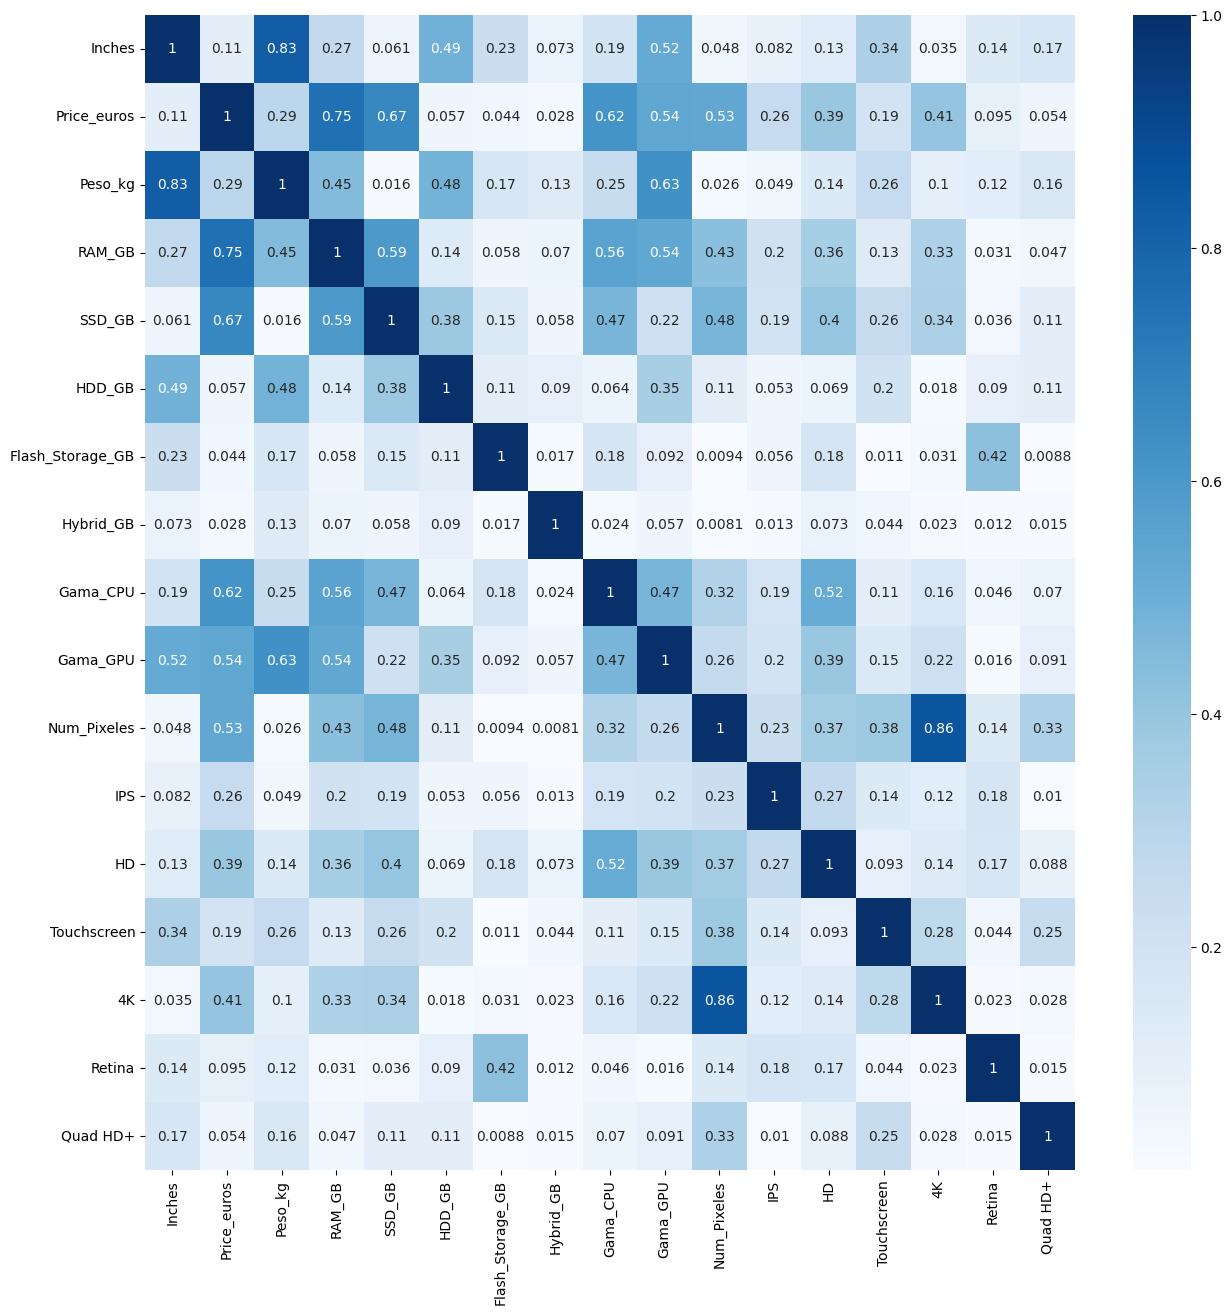

In [122]:
plt.figure(figsize= (15,15))
sns.heatmap(np.abs(corr), annot= True, cmap = "Blues")

In [125]:
columns_exclude.append('Inches')

In [126]:
r_min = 0.10
features = corr[target][(np.abs(corr[target]) > r_min)].index.to_list()
features


['Inches',
 'Price_euros',
 'Peso_kg',
 'RAM_GB',
 'SSD_GB',
 'Gama_CPU',
 'Gama_GPU',
 'Num_Pixeles',
 'IPS',
 'HD',
 'Touchscreen',
 '4K']

 ---

# Modelo _0

In [127]:
X_train = train_cat[features].drop(target,axis=1)
y_train = train_cat[target]
X_test = test_cat[features].drop(target,axis=1)
y_test = test_cat[target]

In [79]:
from sklearn import linear_model

In [128]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

In [129]:
y_pred = lr.predict(X_test)
print("MAE:", median_absolute_error(y_test, y_pred).round(4))

MAE: 177.2688


In [66]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

model_names = ["Regresion Lineal","DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]
lr_clf = LinearRegression()
tree_clf = DecisionTreeRegressor(random_state= 42)
rf_clf = RandomForestRegressor(random_state= 42)
xgb_clf = XGBRegressor(random_state = 42)
lgb_clf = LGBMRegressor(random_state= 42, verbose = -100)
cat_clf = CatBoostRegressor(random_state= 42, verbose = False)

model_set = [lr_clf, tree_clf, rf_clf, xgb_clf, lgb_clf, cat_clf]

In [69]:
metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    if nombre == "Regresion Lineal":
        metricas_cv[nombre] = cross_val_score(modelo, X_train_scaled, y_train, cv = 3, scoring = "neg_median_absolute_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 3, scoring = "neg_median_absolute_error")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

LinearRegression()
DecisionTreeRegressor(random_state=42)
RandomForestRegressor(random_state=42)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
LGBMRegressor(random_state=42, verbose=-100)


In [70]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, RMSE_CV: {np.sqrt(-np.mean(valores))}")
print(f"El ganador es {ganador}")

Model <Regresion Lineal>, RMSE_CV: 14.011596244804725
Model <DecisionTree>, RMSE_CV: 12.867017482264057
Model <Random Forest>, RMSE_CV: 12.444528245058647
Model <XGBoost>, RMSE_CV: 12.790348610500224
Model <LightGBM>, RMSE_CV: 12.334272150516103
Model <CatBoost>, RMSE_CV: 12.094586445893805
El ganador es CatBoost


In [58]:
cat_clf = CatBoostRegressor(verbose = False)

param_grid= {'depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'colsample_bylevel': [0.5,1],
          'iterations': [100, 250, 500, 750],
          "border_count": [125,250]
          }


cat_grid = RandomizedSearchCV(cat_clf, 
                               cv = 3,
                               n_iter = 3,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")

cat_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x000001E4C54E33B0>,
                   n_iter=3,
                   param_distributions={'border_count': [125, 250],
                                        'colsample_bylevel': [0.5, 1],
                                        'depth': [3, 6, 12],
                                        'iterations': [100, 250, 500, 750],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4]},
                   scoring='neg_mean_squared_error')

In [59]:
y_pred = cat_grid.best_estimator_.predict(X_test)
print("MAE:", median_absolute_error(y_test, y_pred).round(4))

MAE: 123.1559


In [76]:
cat_clf = CatBoostRegressor(verbose = False)

param_grid= {'depth': [4, 6, 8, 10, 12],
          'learning_rate': [0.001, 0.05, 0.1, 0.2, 0.3, 0.4],
          'colsample_bylevel': [0.5,1],
          'iterations': [100, 250, 500, 750, 1000],
          "border_count": [32, 64, 128, 254],
          'l2_leaf_reg': [1, 3, 5, 7, 9],
          'bagging_temperature': [0, 1, 2, 3, 4],
          'random_strength': [0, 1, 2, 3, 4],
          }


cat_grid = RandomizedSearchCV(cat_clf, 
                               cv = 5,
                               param_distributions= param_grid, 
                               scoring = "neg_median_absolute_error")

cat_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x000001E4C7FFBBC0>,
                   param_distributions={'bagging_temperature': [0, 1, 2, 3, 4],
                                        'border_count': [32, 64, 128, 254],
                                        'colsample_bylevel': [0.5, 1],
                                        'depth': [4, 6, 8, 10, 12],
                                        'iterations': [100, 250, 500, 750,
                                                       1000],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.001, 0.05, 0.1, 0.2,
                                                          0.3, 0.4],
                                        'random_strength': [0, 1, 2, 3, 4]},
                   scoring='neg_median_absolute_error')

In [77]:
y_pred = cat_grid.best_estimator_.predict(X_test)
print("MAE:", median_absolute_error(y_test, y_pred).round(4))

MAE: 139.9999


 ---

# Kaggle: